# Question 04
Find the passengers who have been on more than N flights together within the range (from,to).

## Assumptions
1. "more than 3 flights together" means 4, 5, ... which is bigger than 3. 
2. Data is clearned and not errorneous
3. Timezone consideration is not required

## Approaches
Self product matrix Matrix M * M<sup>T</sup> has diagonal represents the number of flghts of respective passenger, and right top part (row/passenger 1, column/passenger2) represents how many flights passenger2 shares with passenger 1.

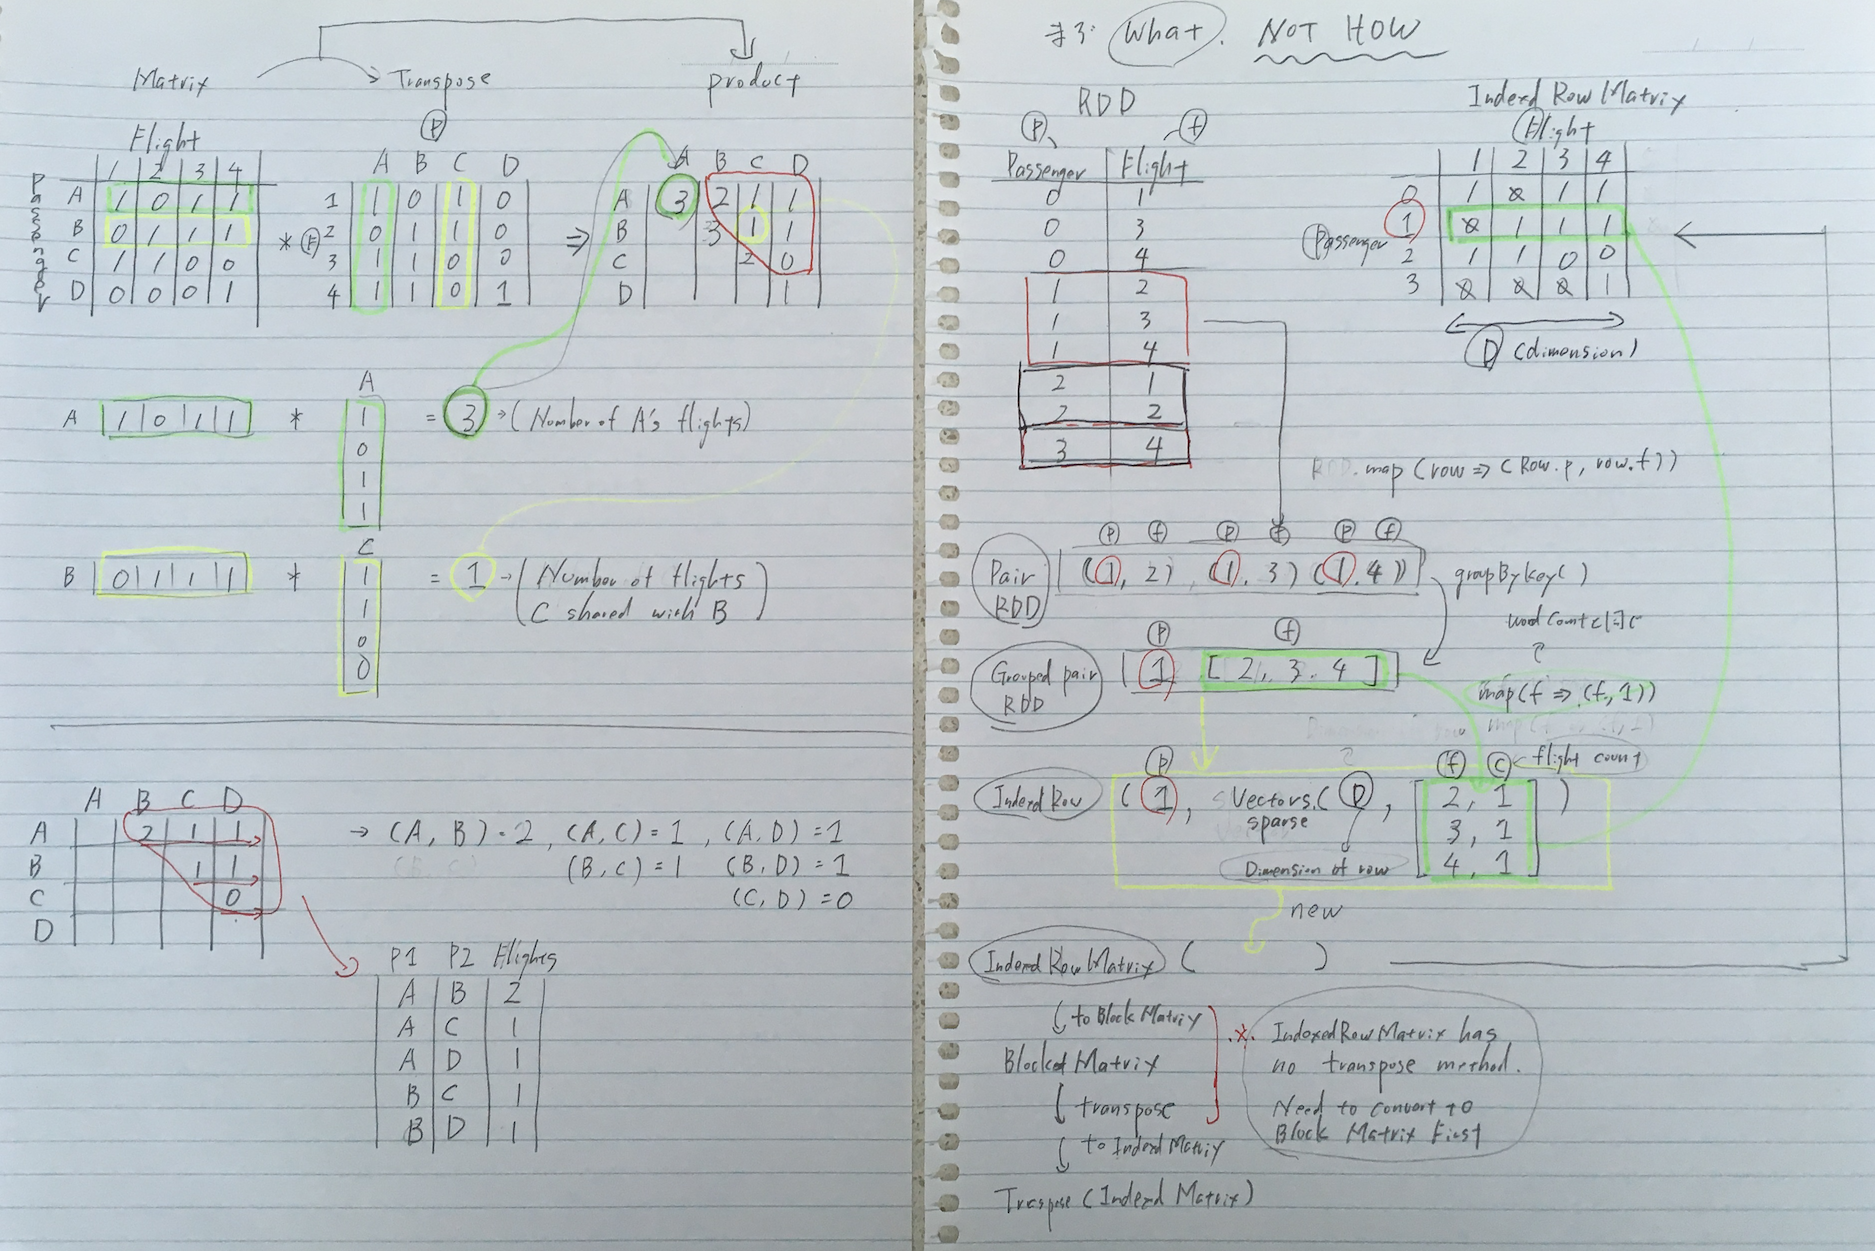

## Considerations

For scalability, adopt Map/Reduce with CoodinateMatrix as in [Scalable Sparse Matrix Multiplication in Apache Spark](https://medium.com/balabit-unsupervised/scalable-sparse-matrix-multiplication-in-apache-spark-c79e9ffc0703).

> Multiply matrices in the MapReduce way in the book Mining of Massive Datasets by Leskovec, Rajaraman and Ullman. 

```
def coordinateMatrixMultiply(
    leftMatrix: CoordinateMatrix,
    rightMatrix: CoordinateMatrix): CoordinateMatrix = 
{
  
  val M_ = leftMatrix.entries
    .map({ case MatrixEntry(i, j, v) => (j, (i, v)) })
  val N_ = rightMatrix.entries
    .map({ case MatrixEntry(j, k, w) => (j, (k, w)) })
  val productEntries = M_
    .join(N_)
    .map({ case (_, ((i, v), (k, w))) => ((i, k), (v * w)) })
    .reduceByKey(_ + _)
    .map({ case ((i, k), sum) => MatrixEntry(i, k, sum) })
  new CoordinateMatrix(productEntries)
}
```

## Output

To avoid having duplicates, passegner 1 ID < passenger ID 2. For instance there will be no (0, 1, 14) and (1, 0, 14) togeher.

# Setup

In [2]:
import org.apache.spark.mllib.linalg._
import org.apache.spark.mllib.linalg.distributed._
import org.apache.spark.rdd.RDD
import org.apache.spark.sql.Row

import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import org.apache.spark.sql.SaveMode
import org.apache.spark.sql.DataFrame

import java.time.temporal.ChronoUnit
import java.time.{Period, LocalDate, Instant}
import java.sql.Timestamp

### Spark parition control based on core availability

In [3]:
val NUM_CORES = 2
val NUM_PARTITIONS = 2

lazy val spark: SparkSession = SparkSession.builder()
    .master("local")
    .appName("flight")
    .getOrCreate()

spark.conf.set("spark.default.parallelism", 8)
spark.conf.set("spark.sql.shuffle.partitions", NUM_CORES * NUM_PARTITIONS)
/*
spark.conf.set("spark.sql.shuffle.partitions", NUM_CORES * NUM_PARTITIONS)
spark.conf.set("spark.default.parallelism", NUM_CORES * NUM_PARTITIONS)
spark.conf.set("spark.driver.memory", "6g")
spark.conf.set("spark.executor.memory", "2g")
spark.conf.set("spark.master", "spark://masa:7077")
*/
import spark.implicits._

NUM_CORES = 2
NUM_PARTITIONS = 2
spark = <lazy>


<lazy>

In [4]:
val configMap = spark.conf.getAll

configMap = Map(spark.driver.host -> 172.16.11.251, spark.driver.port -> 46105, spark.repl.class.uri -> spark://172.16.11.251:46105/classes, spark.jars -> file:/home/masa/.local/share/jupyter/kernels/apache_toree_scala/lib/toree-assembly-0.3.0-incubating.jar, spark.repl.class.outputDir -> /tmp/spark-f0b175ce-34ae-48db-8d64-5ef082ebd9a9/repl-2a616243-8964-4f53-b111-cc9ebdeeffb3, spark.app.name -> flight, spark.driver.memory -> 4g, spark.default.parallelism -> 8, spark.executor.id -> driver, spark.submit.deployMode -> client, spark.master -> local, spark.executor.memory -> 5g, spark.executor.cores -> 4, spark.app.id -> local-1574596009963, spark.sql.shuffle.partitions -> 4)


Map(spark.driver.host -> 172.16.11.251, spark.driver.port -> 46105, spark.repl.class.uri -> spark://172.16.11.251:46105/classes, spark.jars -> file:/home/masa/.local/share/jupyter/kernels/apache_toree_scala/lib/toree-assembly-0.3.0-incubating.jar, spark.repl.class.outputDir -> /tmp/spark-f0b175ce-34ae-48db-8d64-5ef082ebd9a9/repl-2a616243-8964-4f53-b111-cc9ebdeeffb3, spark.app.name -> flight, spark.driver.memory -> 4g, spark.default.parallelism -> 8, spark.executor.id -> driver, spark.submit.deployMode -> client, spark.master -> local, spark.executor.memory -> 5g, spark.executor.cores -> 4, spark.app.id -> local-1574596009963, spark.sql.shuffle.partitions -> 4)

## Constants

In [5]:
val CSV_DELIMITER = ","
//val FLIGHTDATA_CSV_PATH = "test.csv"  // First teset with this as in the snapshot.
val FLIGHTDATA_CSV_PATH = "../resources/flightData.csv"
val PASSENGER_CSV_PATH = "../resources/passengers.csv"

val DATE_FORMAT = "yyyy-MM-dd"
val FLIGHT_DATE_FROM = "2017-01-01"
val FLIGHT_DATE_TO   = "2017-12-31"
val NUM_FLIGHT_TOGETHER = 3

val RESULT_DIR = "results/flightsTogetherMatrix"

val DEBUG = false

CSV_DELIMITER = ,
FLIGHTDATA_CSV_PATH = ../resources/flightData.csv
PASSENGER_CSV_PATH = ../resources/passengers.csv
DATE_FORMAT = yyyy-MM-dd
FLIGHT_DATE_FROM = 2017-01-01
FLIGHT_DATE_TO = 2017-12-31
NUM_FLIGHT_TOGETHER = 3
RESULT_DIR = results/flightsTogetherMatrix
DEBUG = false


false

# Tools

### Elapsed time profiler

In [6]:
import scala.collection.mutable.ListBuffer

val timing = new StringBuffer
val times = new ListBuffer[Long]()

def clear(): Unit = {
    timing.setLength(0)
    times.clear
}
def average(): Long = {
    times.reduce(_+_) / times.length
}

/**
@param label Description about the run
@code code to execute
@return execution
*/
def timed[T](label: String, code: => T): T = {
    val start = System.currentTimeMillis()
    val result = code
    val stop = System.currentTimeMillis()
    timing.append(s"Processing $label took ${stop - start} ms.\n")
    times.append(stop - start)
    result
}

timing = 
times = ListBuffer()


clear: ()Unit
average: ()Long
timed: [T](label: String, code: => T)T


ListBuffer()

In [7]:
// To flush out error: missing argument list for method timed
println("")

<console>:53: error: missing argument list for method timed
Unapplied methods are only converted to functions when a function type is expected.
You can make this conversion explicit by writing `timed _` or `timed(_,_)` instead of `timed`.
       timed
       ^
lastException: Throwable = null


### Save to file

In [8]:
def save(df: DataFrame) = {
    df.coalesce(1)
    .write
    .format("csv")
    .mode(SaveMode.Overwrite)
    .option("header", "true")
    .save(RESULT_DIR)
}

save: (df: org.apache.spark.sql.DataFrame)Unit


# Main

## DataFrame\[passengerId, flightId\]

In [9]:
// Transformations, no action yet
val schema = StructType(Array(
    StructField("passengerId",IntegerType,true), 
    StructField("flightId" ,IntegerType,true), 
    StructField("from",StringType,true), 
    StructField("to",StringType,true), 
    StructField("date",TimestampType,true)
))  

val flightData = spark.read.format("csv")
    .schema(schema)
    .option("header", "true")
    .option("delimiter", ",")
    .option("dateFormat", "yyyy-MM-dd")
    //.option("inferSchema", "true")
    .load(FLIGHTDATA_CSV_PATH)
    .selectExpr(
        // NOTE_PASSENGER_ID_ADJUST: To start passengerId from 0
        "passengerId - 1 AS passengerId", 
        "flightId"
    )
    /*
    .orderBy(
        asc("passengerId"), 
        asc("flightId")
    )
    */

val maxPassengerId = flightData
    .select(max("passengerId"))
    .first
    .getInt(0)

val maxFlightId = flightData
    .select(max("flightId"))
    .first
    .getInt(0)

schema = StructType(StructField(passengerId,IntegerType,true), StructField(flightId,IntegerType,true), StructField(from,StringType,true), StructField(to,StringType,true), StructField(date,TimestampType,true))
flightData = [passengerId: int, flightId: int]
maxPassengerId = 15499
maxFlightId = 999


999

## Passenger to flight counters as RDD\[IndexedRow\]
Convert each Dataframe row (passengerId, flightId) into (passegnerId, (flightId, 1)+) pair as an IndexedRow.  
e.g. for passenger 1 who had flights \[1, 16, 234\]:

<pre>
[ (1, (1,  1.0)   // passengerId 1 had flightId 1  for 1.0 times.  
  (1, (16, 1.0)   // passegnerId 1 had flightId 16 for 1.0 times
  (1, (234,1.0) ]  
</pre>

as
<pre>
RDD[IndexedRow(  
  passengerId,  
  Vectors.sparse(
      totalFlights,  
      Iterable(flightId, 1.0)    
  )
]
</pre>

In [10]:
/**
Create a IndexedRow that maps a passengerId to a sparse vector of (flightId, 1)+
from (passengerId, Iterable[flightId]).

The dimension of the vector in IndexedRow is the number of total flights so that
we can mark each flight per passenger in the (passengerId/row, flightId/column) matrix

@param passengerToFlightsKV (passengerId, Iterable(flightId)) key value pair
@param maxFlightId maximum flightId
@Return 
    IndexedRow(  
      passengerId,  
      Vectors.sparse(
          totalFlights,  
          Iterable(flightId, 1.0)    
      )
    ]
*/
def toIndexedRow(passengerToFlightsMap:(Int, Iterable[Int]), maxFlightId: Int): IndexedRow = {
    passengerToFlightsMap match {
        case (passengerId, flightIDs) => {
            //--------------------------------------------------------------------------------
            // flightIDs to Seq((flightId, 1)) eg
            // (1, 16, 234) => 
            // [ (1,   1),   <-- (flightId 1,   count 1)
            //   (16,  1),   <-- (flightId 16,  count 1)
            //   (234, 1) ]  <-- (flightId 234, count 1)
            //--------------------------------------------------------------------------------
            val flightCountKV = flightIDs.map(i => (i, 1.0)).toSeq

            //--------------------------------------------------------------------------------
            // IndexedRow(passengerId, Vector((flightID, 1)))
            // When passengerId 1 took flight (1, 16, 234) then
            // IndexedRow(1, ((1, 1), (16, 1), (234, 1))
            //
            // Allocate storage to accommodate maxFlightId + 1.
            //--------------------------------------------------------------------------------
            new IndexedRow (
                passengerId,
                Vectors.sparse(maxFlightId + 1, flightCountKV)
            )
        }
    }
}

/*val row = toIndexedRow(
    (1, Iterable(29, 75, 101, 131, 189, 217, 247, 320, 352, 362, 717, 736, 740)),
    totalFlights.toInt
)
row
*/

toIndexedRow: (passengerToFlightsMap: (Int, Iterable[Int]), maxFlightId: Int)org.apache.spark.mllib.linalg.distributed.IndexedRow


In [11]:
val passengerToFlightCounters= flightData.rdd
    .map(rowPF => (rowPF.getInt(0), rowPF.getInt(1)))  // Out from ROW[(passengerId, flightId)]
    .groupByKey()                                      // (passengerId, Iterable(flightId))
//    .sortBy(row => row._1)                           // sort asc(passengerId)
    .map(
        passengerToFlightIDsMap => toIndexedRow(passengerToFlightIDsMap, maxFlightId)
    )                                            // IndexedRow(passengerId, Vector((flightId, 1)))

if (DEBUG){
    passengerToFlightCounters.take(3).foreach(println)
    passengerToFlightCounters.count()
}

passengerToFlightCounters = MapPartitionsRDD[20] at map at <console>:61


()

## Matrix M of (passengerId/row, flightId/col)

* IndexedRowMatrix [multiply](https://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.mllib.linalg.distributed.IndexedRowMatrix@multiply(B:org.apache.spark.mllib.linalg.Matrix):org.apache.spark.mllib.linalg.distributed.IndexedRowMatrix) method requires *a local matrix* on the right.
* [BlockMatrix](https://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.mllib.linalg.distributed.BlockMatrix) is the only Spark matrix that supports multiply in distributed manner.

In [12]:
//--------------------------------------------------------------------------------
// Create IndexedRowMatrix of (passengerId as row, flightId as column) with binary 
// 0.0 or 1.0 as its value to mark if the passenger took the flightId.
// The passengerId is the index to sort by asc(passengerId).
// 
// IndexedRowMatrix multiply method requires a local matrix on the right.
// BlockMatrix is the only Spark matrix that supports multiply in distributed manner.
//--------------------------------------------------------------------------------
// IndexedRow matrix
val passengerFlightIndexedMatrix = new IndexedRowMatrix(passengerToFlightCounters)

if (DEBUG){
    val rowNums = passengerFlightIndexedMatrix.numRows
    val colNums = passengerFlightIndexedMatrix.numCols
    println(s"($rowNums, $colNums)")
    println(passengerFlightIndexedMatrix.getClass)

    passengerFlightIndexedMatrix
        .rows                    // RDD[IndexedRow] where IndexedRow is (index, vector)
//        .sortBy(iv => iv.index)  // Sort by IndexedRow.index
        .cache
        .toDF
        .show(true)
}

passengerFlightIndexedMatrix = org.apache.spark.mllib.linalg.distributed.IndexedRowMatrix@24940953


org.apache.spark.mllib.linalg.distributed.IndexedRowMatrix@24940953

In [13]:
// BlockMatrix
val passengerFlightBlockMatrix = passengerFlightIndexedMatrix.toBlockMatrix

passengerFlightBlockMatrix = org.apache.spark.mllib.linalg.distributed.BlockMatrix@714b2883


org.apache.spark.mllib.linalg.distributed.BlockMatrix@714b2883

### Transpose M<sup>T</sup>

In [14]:
val passengerFlightBlockMatrixTransposed = passengerFlightBlockMatrix
    .transpose

if (DEBUG){
    println(passengerFlightBlockMatrixTransposed.getClass)
    println(
        passengerFlightBlockMatrixTransposed.numRows, 
        passengerFlightBlockMatrixTransposed.numCols
    )
}

passengerFlightBlockMatrixTransposed = org.apache.spark.mllib.linalg.distributed.BlockMatrix@2d8a4477


org.apache.spark.mllib.linalg.distributed.BlockMatrix@2d8a4477

## Product of M * M<sup>T</sup> as Flown Together Matrix

In [15]:
val flightsTogetherIndexedMatrix = passengerFlightBlockMatrix
    .multiply(passengerFlightBlockMatrixTransposed)
    .toIndexedRowMatrix

if (DEBUG){
    val numRows = flightsTogetherIndexedMatrix.numRows
    val numCols = flightsTogetherIndexedMatrix.numCols
    println(flightsTogetherIndexedMatrix.getClass)
    println(s"shape is $numRows, $numCols")
    
    //--------------------------------------------------------------------------------
    // View the result in DataFrame
    //--------------------------------------------------------------------------------
    flightsTogetherIndexedMatrix
        .rows                    // RDD[IndexedRow] where IndexedRow is (index, vector)
        //.sortBy(iv => iv.index)  // Sort by IndexedRow.index
        .toDF
        .selectExpr(
            "index AS passengerId",
            "vector AS companionIDs"
        )
        .show(true)
}

flightsTogetherIndexedMatrix = org.apache.spark.mllib.linalg.distributed.IndexedRowMatrix@3fdd6f9a


org.apache.spark.mllib.linalg.distributed.IndexedRowMatrix@3fdd6f9a

## RDD(passengerId, companionId, numFlightsShared)

In [34]:
/**
    row(passengerId, numsFlightsTogether) is each row of the M*M.T product.
    
    numsFlightsTogether is a list of numbers each of which tells the number of flights
    shared with another passenger.
    
    numsFlightsTogether(0) For a passengerId 0
    --------------------------------------------------------------------------------
    (index) |0  |1|2|3|4|5|6|
    (number)|100|3|0|1|2|0|0|  <-- Total flights of passengerId 0 is 100.
                                   Shared 3 flights with passengerId 1.
                                   Shared 1 flights with passengerId 2 ...

    numsFlightsTogether(1) For a passengerId 1
    --------------------------------------------------------------------------------
    (index) |0|1  |2|3|4|5|6|
    (number)|3|100|7|0|2|0|0|  <-- Total flights of passengerId 1 is 100.
                                   Shared 3 flights with passengerId 0
                                   Shared 7 flights with passengerId 2 ...

    numsFlightsTogether(2) For a passengerId 2
    --------------------------------------------------------------------------------
    (index) |0|1|2  |3|4|5|6|
    (number)|0|7|100|0|2|0|0|  <-- Total flights of passengerId 2 is 100.
                                   Shared 0 flights with passengerId 0
                                   Shared 7 flights with passengerId 1 ...

@param row (passengerId, numsFlightsTogether)
@return Seq(passengerId, companionId, numberOfFlightsShared)
 */
def flownTogether(passengerFlightsTuple: (Int, Array[Double]), threshold:Int = NUM_FLIGHT_TOGETHER) = {
    val _index = passengerFlightsTuple._1
    val _array = passengerFlightsTuple._2
    val passengerId = _index          // passengerId itself is the row index
    val numsFlightsTogether = _array  // number of flights shared another
    
    for{
        fellowPassengerId <- (passengerId + 1 to maxPassengerId)
        if(numsFlightsTogether(fellowPassengerId) > threshold)
    } yield (
        //-------------------------------------------------------------------------------
        // NOTE_PASSENGER_ID_ADJUST: Subtracted -1 ao start passengerId from 0
        // Hence, revert to original as it starts at 1, not 0 
        //-------------------------------------------------------------------------------
        passengerId + 1,               
        fellowPassengerId + 1, 
        numsFlightsTogether(fellowPassengerId)
    )
}

/* Check first
val first = flightTogetherMatrix.rows.first
flownTogether(first.index.toInt, first.vector.toArray)
*/

flownTogether: (passengerFlightsTuple: (Int, Array[Double]), threshold: Int)scala.collection.immutable.IndexedSeq[(Int, Int, Double)]


In [35]:
val flightTogetherRDD = flightsTogetherIndexedMatrix
    .rows
    //--------------------------------------------------------------------------------
    // Convert row of product M*M.T into (passengerId, compaionId, numFlightsShared).
    //--------------------------------------------------------------------------------
    .flatMap(
        indexedRow => flownTogether(
            (indexedRow.index.toInt, indexedRow.vector.toArray),
            NUM_FLIGHT_TOGETHER
        )
    )
    //--------------------------------------------------------------------------------
    // Sort (passengerId, companionId, numFlightsShared)._1
    //--------------------------------------------------------------------------------
    //.sortBy(pcn => pcn._3, false)
    //.saveAsText(RESULT_DIR)

flightTogetherRDD = MapPartitionsRDD[80] at flatMap at <console>:61


MapPartitionsRDD[80] at flatMap at <console>:61

## DataFrame

In [36]:
val flightTogetherDF = flightTogetherRDD
    .toDF
    .selectExpr(
        "_1 AS `Passenger 1 ID`",
        "_2 AS `Passenger 2 ID`",
        "CAST(_3 AS Int) AS `Number of flights together`"        
    )
    .sort(
        desc("Number of flights together"),
        asc("Passenger 1 ID"),
        asc("Passenger 2 ID")
    )

flightTogetherDF = [Passenger 1 ID: int, Passenger 2 ID: int ... 1 more field]


[Passenger 1 ID: int, Passenger 2 ID: int ... 1 more field]

In [41]:
timed(
    "Flight togethe matrix",
    save(flightTogetherDF)
)

In [40]:
println(timing)
flightTogetherDF.show(3)

Processing Flight togethe matrix took 8591 ms.
Processing Flight togethe matrix took 17730 ms.
Processing Flight togethe matrix took 17160 ms.
Processing Flight togethe matrix took 17551 ms.

+--------------+--------------+--------------------------+
|Passenger 1 ID|Passenger 2 ID|Number of flights together|
+--------------+--------------+--------------------------+
|           701|           760|                        15|
|          2717|          2759|                        14|
|          3503|          3590|                        14|
+--------------+--------------+--------------------------+
only showing top 3 rows

